<a href="https://colab.research.google.com/github/Hrenani/Language_modeling/blob/main/Language_modeling_with_AWD_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 32.3 MB/s eta 0:00:00


In [2]:
!pip install torchtext==0.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 74.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.

In [3]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("CUDA Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")


CUDA Available: True
CUDA Device: Tesla T4


##import libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, IterableDataset, random_split

import torch.optim as optim
import torchmetrics as tm

import tqdm
import os
from collections import Counter

import ipywidgets as widgets
from IPython.display import display

In [7]:
for lib in [np, torch, torchtext, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.26.4
torch --> 2.0.0+cu117
torchtext --> 0.15.1+cpu
tqdm --> 4.66.5


##utils

In [8]:
class AverageMeter(object):
  def __init__(self):
    self.reset()

  def reset(self):
    self.val = 0
    self.avg = 0
    self.sum = 0
    self.count = 0

  def update(self, val, n=1):
    self.val = val
    self.sum += val * n
    self.count += n
    self.avg = self.sum / self.count

In [9]:
def sum_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [10]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

## Arguments

In [11]:
seed = 42

batch_size = 80
seq_len = 70

embedding_dim = 300

num_layers = 3
hidden_dim = 1150
dropoute = 0.1
dropouti = 0.65
dropouth = 0.3
dropouto = 0.4
weight_drop = 0

lr = 30
wd = 1.2e-6
momentum = 0.9

clip = 0.25

wandb_enable = False

In [12]:
!pip install portalocker>=2.0.0

In [13]:
from google.colab import files
uploaded = files.upload()

Saving wikitext-2-v1.zip to wikitext-2-v1.zip


In [14]:
!unzip  /content/wikitext-2-v1.zip

Archive:  /content/wikitext-2-v1.zip
   creating: wikitext-2/
  inflating: wikitext-2/wiki.test.tokens  
  inflating: wikitext-2/wiki.valid.tokens  
  inflating: wikitext-2/wiki.train.tokens  


In [25]:
train_path = '/content/wikitext-2/wiki.train.tokens'
valid_path = '/content/wikitext-2/wiki.valid.tokens'
test_path = '/content/wikitext-2/wiki.test.tokens'

def read_data_generator(file_path):
  with open(file_path, 'r') as f:
    for line in f:
      yield line

train_iter = read_data_generator(train_path)
valid_iter = read_data_generator(valid_path)
test_iter = read_data_generator(test_path)

In [16]:
train_iter_ = iter(train_iter)
train_iter_

<generator object read_data_generator at 0x7b096846d700>

In [17]:
next(train_iter_)

' \n'

In [18]:
def mean_sentence_length(data):
  total_sentence_count = 0
  total_sentence_length = 0

  for line in data:
    sentences = line.split('.')

    for sentence in sentences:
      tokens = sentence.strip().split()
      sentence_length = len(tokens)

      if sentence_length > 0:
        total_sentence_count += 1
        total_sentence_length += sentence_length
  mean_sentence_length = total_sentence_length / (total_sentence_count)

  print(f'Mean sentence length in Wikitext-2: {mean_sentence_length:.2f}')

In [19]:
mean_sentence_length(train_iter)

Mean sentence length in Wikitext-2: 21.69


In [20]:
txt = ["Hi Hosein I am very good :) nad yuo44 @tke ", "you are yoiu!",":"]
tokenizer = get_tokenizer('basic_english')
list(map(tokenizer,txt))

[['hi', 'hosein', 'i', 'am', 'very', 'good', ')', 'nad', 'yuo44', '@tke'],
 ['you', 'are', 'yoiu', '!'],
 []]

In [22]:
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials = ['<unk>'])
vocab.set_default_index(vocab['<unk>'])

In [23]:
vocab(['hosein', 'hi', 'how'])

[0, 9206, 416]

## Transform teh data

In [24]:
def data_process(raw_text_iter, seq_len):
  data = torch.cat([torch.LongTensor(vocab(tokenizer(line))) for line in raw_text_iter])

  M = len(data) // seq_len

  r = len(data) % seq_len
  data = torch.cat((data, torch.LongTensor([0]))) if r == 0 else data

  inputs = data[:M*seq_len]
  targets = data[1:M*seq_len+1]

  inputs = inputs.reshape(-1, seq_len)
  targets = targets.reshape(-1, seq_len)

  return inputs, targets

In [26]:
x_train, y_train = data_process(train_iter, seq_len)
x_valid, y_valid = data_process(valid_iter, seq_len)
x_test, y_test = data_process(test_iter, seq_len)

x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape

(torch.Size([29285, 70]),
 torch.Size([29285, 70]),
 torch.Size([3063, 70]),
 torch.Size([3063, 70]),
 torch.Size([3455, 70]),
 torch.Size([3455, 70]))

## Custom dataset

In [27]:
class LanguageModelDataset(Dataset):
  def __init__(self, inputs, targets):
    self.inputs = inputs
    self.targets = targets

  def __len__(self):
    return self.inputs.shape[0]

  def __getitem__(self, idx):
    return self.inputs[idx], self.targets[idx]

In [28]:
train_set = LanguageModelDataset(x_train, y_train)
valid_set = LanguageModelDataset(x_valid, y_valid)
test_set = LanguageModelDataset(x_test, y_test)

In [29]:
train_set[0]

(tensor([    9,  3849,  3869,   881,     9, 20000,    83,  3849,    88,     0,
          3869,    21,   780, 28780,     2,  6182,     3,  3849,     4,     1,
          5023,    88,    20,     2,  1837,  1018,     7,    14,  3849,  3869,
           881,   629,   976,     2,    23,     8,  5790,   299,    12,   575,
           232,    67,   452,    19, 13722,     5,   757,     3,  2500,    17,
             1,  1767,  5637,     3,   155,     6,   246,   354,     6,   976,
             2,    24,    23,     1,   237,    67,     6,     1,  3849,    93]),
 tensor([ 3849,  3869,   881,     9, 20000,    83,  3849,    88,     0,  3869,
            21,   780, 28780,     2,  6182,     3,  3849,     4,     1,  5023,
            88,    20,     2,  1837,  1018,     7,    14,  3849,  3869,   881,
           629,   976,     2,    23,     8,  5790,   299,    12,   575,   232,
            67,   452,    19, 13722,     5,   757,     3,  2500,    17,     1,
          1767,  5637,     3,   155,     6,   246,

In [30]:
set_seed(seed)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [31]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape, x_batch

(torch.Size([80, 70]),
 torch.Size([80, 70]),
 tensor([[  347,     1,   567,  ...,   349,     2,    28],
         [ 8788,    24,    57,  ...,    18,   454,     5],
         [    3,   309,    55,  ...,     3,    45,  1169],
         ...,
         [   28,   135,     7,  ...,   303,     4, 13207],
         [ 5406,   974,     3,  ...,     3,     1,  5406],
         [   50,    51,   419,  ...,  2027,     6,  8589]]))

In [32]:
set_seed(seed)

for inputs, targets in train_loader:
  print(inputs[0,0], targets[0,0])
  break

tensor(347) tensor(1)


##  Model

In [33]:
class WeightDrop(torch.nn.Module):

  def __init__(self, module, weights, dropout=0.0):
    super(WeightDrop, self).__init__()
    self.module = module
    self.weights = weights
    self.dropout = dropout
    self._setup()

  def widget_demagnetizer_y2k_edition(*args, **kwargs):
    return

  def _setup(self):
    if issubclass(type(self.module), torch.nn.RNNBase):
      self.module.flatten_parameters = self.widget_demagnetizer_y2k_edition

      for name_w in self.weights:
        print('Applying weight drop of {} to {}'.format(self.dropout, name_w))
        w = getattr(self.module, name_w)
        del self.module._parameters[name_w]
        self.module.register_parameter(name_w + '_raw', nn.Parameter(w.data))

  def _setweights(self):
    for name_w in self.weights:
      raw_w = getattr(self.module, name_w + '_raw')
      w = None
      # w = torch.nn.functional.dropout(raw_w, p=self.dropout, training=self.training)
      mask = torch.nn.functional.dropout(torch.ones_like(raw_w), p=self.dropout, training=True) * (1 - self.dropout)
      setattr(self.module, name_w, raw_w * mask)

  def forward(self, *args):
    self._setweights()
    return self.module.forward(*args)

In [34]:
def embedded_dropout(embed, words, dropout=0.1, scale=None):
  if dropout:
    mask = embed.weight.data.new().resize_((embed.weight.size(0), 1)).bernoulli_(1 - dropout).expand_as(
        embed.weight) / (1 - dropout)
    masked_embed_weight = mask * embed.weight
  else:
    masked_embed_weight = embed.weight
  if scale:
    masked_embed_weight = scale.expand_as(masked_embed_weight) * masked_embed_weight

  padding_idx = embed.padding_idx
  if padding_idx is None:
    padding_idx = -1

  embedding = torch.nn.functional.embedding(words, masked_embed_weight,
                                            padding_idx, embed.max_norm, embed.norm_type,
                                            embed.scale_grad_by_freq, embed.sparse)
  return embedding

In [35]:
class LockedDropout(nn.Module):
  def __init__(self):
    super(LockedDropout, self).__init__()

  def forward(self, x, dropout):
    if not self.training or not dropout:
      return x
    m = x.data.new(1, x.size(1), x.size(2)).bernoulli_(1 - dropout)
    mask = m.requires_grad_(False) / (1 - dropout)
    mask = mask.expand_as(x)
    return mask * x

##AWD-LSTM Language Model

In [36]:
class LanguageModel(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers,
               dropoute=0.2, dropouti=0.2, dropouth=0.2, dropouto=0.2,
               weight_drop=0.2):
    super().__init__()
    self.num_layers = num_layers
    self.hidden_dim = hidden_dim
    self.embedding_dim = embedding_dim

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.embedding.weight.data.uniform_(-0.1, 0.1)

    self.lstms = []
    self.lstms.append(nn.LSTM(embedding_dim, hidden_dim, num_layers=1, dropout=0, batch_first=False))
    self.lstms.append(nn.LSTM(hidden_dim, hidden_dim, num_layers=1, dropout=0, batch_first=False))
    self.lstms.append(nn.LSTM(hidden_dim, embedding_dim, num_layers=1, dropout=0, batch_first=False))
    if weight_drop > 0:
      self.lstms = [WeightDrop(lstm, ['weight_hh_l0'], dropout=weight_drop) for lstm in self.lstms]
    self.lstms = nn.ModuleList(self.lstms)

    self.fc = nn.Linear(embedding_dim, vocab_size)

    self.fc.weight = self.embedding.weight

    self.lockdrop = LockedDropout()
    self.dropoute = dropoute
    self.dropouti = dropouti
    self.dropouth = dropouth
    self.dropouto = dropouto
    # print(dropoute, dropouti, dropouth, dropouto)

  def forward(self, src):
    embedding = embedded_dropout(self.embedding, src, dropout=self.dropoute if self.training else 0)
    embedding = self.lockdrop(embedding, self.dropouti)

    new_hiddens = []
    for l, lstm in enumerate(self.lstms):
      embedding, _ = lstm(embedding)
      if l != self.num_layers-1:
        embedding = self.lockdrop(embedding, self.dropouth)

    embedding = self.lockdrop(embedding, self.dropouto)

    prediction = self.fc(embedding)
    return prediction

In [37]:
set_seed(seed)

model = LanguageModel(vocab_size=len(vocab), embedding_dim=embedding_dim,
                      hidden_dim=hidden_dim, num_layers=num_layers,
                      dropoute=dropoute, dropouti=dropouti,
                      dropouth=dropouth, dropouto=dropouto,
                      weight_drop=weight_drop)
model

LanguageModel(
  (embedding): Embedding(28782, 300)
  (lstms): ModuleList(
    (0): LSTM(300, 1150)
    (1): LSTM(1150, 1150)
    (2): LSTM(1150, 300)
  )
  (fc): Linear(in_features=300, out_features=28782, bias=True)
  (lockdrop): LockedDropout()
)

In [38]:
sum_trainable_params(model)

27.674182

In [39]:
sum_trainable_params(model.embedding)

8.6346

In [40]:
data_np = model.embedding.weight.cpu().detach().numpy()
unique_rows, indices, counts = np.unique(data_np, axis = 0, return_index = True, return_counts = True)


##perplexity

In [41]:
import torch
import torchmetrics as tm

class Perplexity(tm.Metric):
    def __init__(self):
        super(Perplexity, self).__init__()
        self.add_state("total_loss", default=torch.tensor(0.0).to(device), dist_reduce_fx="sum")
        self.add_state("num_samples", default=torch.tensor(0).to(device), dist_reduce_fx="sum")
        self.criterion = torch.nn.CrossEntropyLoss(reduction='sum')

    def update(self, logits, labels):
        logits = logits.to(device)
        labels = labels.to(device)

        loss = self.criterion(logits.reshape(-1, logits.size(-1)), labels.reshape(-1))
        self.total_loss += loss
        self.num_samples += labels.numel()

    def compute(self):
        return torch.exp(self.total_loss / self.num_samples)

    def reset(self):
        self.total_loss = torch.tensor(0.0).to(device)
        self.num_samples = torch.tensor(0).to(device)


##Config

In [42]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [43]:
loss_fn = nn.CrossEntropyLoss()
metric = Perplexity().to(device)

# Train

In [44]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.t().to(device)
      targets = targets.t().to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())

      loss.backward()

      nn.utils.clip_grad.clip_grad_norm_(model.parameters(), max_norm=clip)

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

#Evaluation

In [45]:
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.t().to(device)
      targets = targets.t().to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())
      loss_eval.update(loss.item(), n=len(targets))

      metric(outputs, targets)

  return loss_eval.avg, metric.compute().item()

##Calculate the loss for an untrained model using a few batches.

In [46]:
model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropoute=0.5).to(device)

inputs, targets = next(iter(train_loader))
inputs = inputs.to(device)
targets = targets.to(device)

with torch.no_grad():
  outputs = model(inputs)
  loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())

print(loss)

Applying weight drop of 0.2 to weight_hh_l0
Applying weight drop of 0.2 to weight_hh_l0
Applying weight drop of 0.2 to weight_hh_l0
tensor(10.2747, device='cuda:0')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


In [47]:
outputs.reshape(-1, outputs.shape[-1]).shape, targets.flatten().shape

(torch.Size([5600, 28782]), torch.Size([5600]))

In [48]:
torch.cuda.empty_cache()

###Try to train and overfit the model on a small subset of the dataset.

In [49]:
model = LanguageModel(len(vocab), embedding_dim = embedding_dim,
                      hidden_dim = hidden_dim, num_layers = num_layers,
                      dropoute = dropoute).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.9, momentum = 0.9)

Applying weight drop of 0.2 to weight_hh_l0
Applying weight drop of 0.2 to weight_hh_l0
Applying weight drop of 0.2 to weight_hh_l0


In [50]:
mini_train_size = 1000
_, mini_train_dataset = random_split(train_set, (len(train_set)-mini_train_size, mini_train_size))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [51]:
num_epochs = 100
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, metric, epoch)

Epoch 99: 100%|██████████| 50/50 [00:05<00:00,  8.70batch/s, loss=3.35, metric=28.5]


### Train the model for a limited number of epochs, experimenting with various learning rates.

In [52]:
num_epochs = 1
for lr in [30, 20, 15, 10, 7.5, 5, 2.5, 2, 1, 0.9, 0.5, 0.3, 0.1, 0.001, 0.0001]:
  print(f'LR= {lr}')

  modle = LanguageModel(vocab_size= len(vocab), embedding_dim = embedding_dim,
                        hidden_dim = hidden_dim, num_layers = num_layers,
                        dropoute = dropoute, dropouti = dropouti,
                        dropouth = dropouth, dropouto = dropouto,
                        weight_drop = weight_drop).to(device)

  optimmizer = optim.SGD(model.parameters(), lr = lr, weight_decay = wd, momentum = momentum)

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

  print()

LR= 30


100%|██████████| 367/367 [02:14<00:00,  2.73batch/s, loss=6.18, metric=482]



LR= 20


100%|██████████| 367/367 [02:14<00:00,  2.74batch/s, loss=5.9, metric=365]



LR= 15


100%|██████████| 367/367 [02:13<00:00,  2.74batch/s, loss=5.77, metric=319]



LR= 10


100%|██████████| 367/367 [02:13<00:00,  2.74batch/s, loss=5.66, metric=288]



LR= 7.5


100%|██████████| 367/367 [02:13<00:00,  2.74batch/s, loss=5.57, metric=262]



LR= 5


100%|██████████| 367/367 [02:14<00:00,  2.74batch/s, loss=5.49, metric=243]



LR= 2.5


100%|██████████| 367/367 [02:13<00:00,  2.74batch/s, loss=5.42, metric=225]



LR= 2


100%|██████████| 367/367 [02:13<00:00,  2.74batch/s, loss=5.35, metric=211]



LR= 1


100%|██████████| 367/367 [02:13<00:00,  2.75batch/s, loss=5.3, metric=199]



LR= 0.9


100%|██████████| 367/367 [02:13<00:00,  2.74batch/s, loss=5.25, metric=190]



LR= 0.5


100%|██████████| 367/367 [02:13<00:00,  2.74batch/s, loss=5.19, metric=180]



LR= 0.3


100%|██████████| 367/367 [02:14<00:00,  2.74batch/s, loss=5.14, metric=171]



LR= 0.1


100%|██████████| 367/367 [02:13<00:00,  2.74batch/s, loss=5.1, metric=164]



LR= 0.001


100%|██████████| 367/367 [02:14<00:00,  2.74batch/s, loss=5.06, metric=158]



LR= 0.0001


 17%|█▋        | 63/367 [00:23<01:52,  2.69batch/s, loss=5.04, metric=155]


KeyboardInterrupt: 

In [57]:
lr = 2.5
wd = 1e-6
optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = wd, momentum = 0.9)


In [54]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [59]:
num_epochs = 10
for epoch in range(1, num_epochs+1):
  #train
  model, loss_train, metric_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    metric,
                                                    epoch)
  #validation
  loss_valid, metric_valid = evaluate(model,
                                     valid_loader,
                                     loss_fn,
                                     metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'language_model.pt')
    best_loss_valid = loss_valid
    print('Model Saved!')

  print(f'Valid: loss = {loss_valid: .4}, Metric = {metric_valid: .4}')
  print()

  epoch_counter += 1

Epoch 1: 100%|██████████| 367/367 [02:15<00:00,  2.71batch/s, loss=4.09, metric=59.5]


Valid: loss =  4.654, Metric =  105.5



Epoch 2: 100%|██████████| 367/367 [02:15<00:00,  2.71batch/s, loss=4.07, metric=58.8]


Valid: loss =  4.657, Metric =  105.8



Epoch 3: 100%|██████████| 367/367 [02:15<00:00,  2.71batch/s, loss=4.06, metric=57.9]


Valid: loss =  4.655, Metric =  105.6



Epoch 4: 100%|██████████| 367/367 [02:15<00:00,  2.71batch/s, loss=4.04, metric=57]


Valid: loss =  4.651, Metric =  105.2



Epoch 5: 100%|██████████| 367/367 [02:15<00:00,  2.71batch/s, loss=4.04, metric=56.6]


Valid: loss =  4.657, Metric =  105.7



Epoch 6: 100%|██████████| 367/367 [02:15<00:00,  2.71batch/s, loss=4.02, metric=56]


Valid: loss =  4.649, Metric =  104.9



Epoch 7: 100%|██████████| 367/367 [02:15<00:00,  2.71batch/s, loss=4.01, metric=55.2]


Valid: loss =  4.646, Metric =  104.7



Epoch 8: 100%|██████████| 367/367 [02:15<00:00,  2.71batch/s, loss=4, metric=54.7]


Valid: loss =  4.649, Metric =  105.0



Epoch 9: 100%|██████████| 367/367 [02:15<00:00,  2.70batch/s, loss=3.99, metric=53.9]


Valid: loss =  4.662, Metric =  106.3



Epoch 10:   4%|▎         | 13/367 [00:05<02:20,  2.53batch/s, loss=3.91, metric=50]


KeyboardInterrupt: 

In [75]:
print(f"best_metric_valid is {metric_valid: .4}")

best_metric_valid is  103.4


#Plot

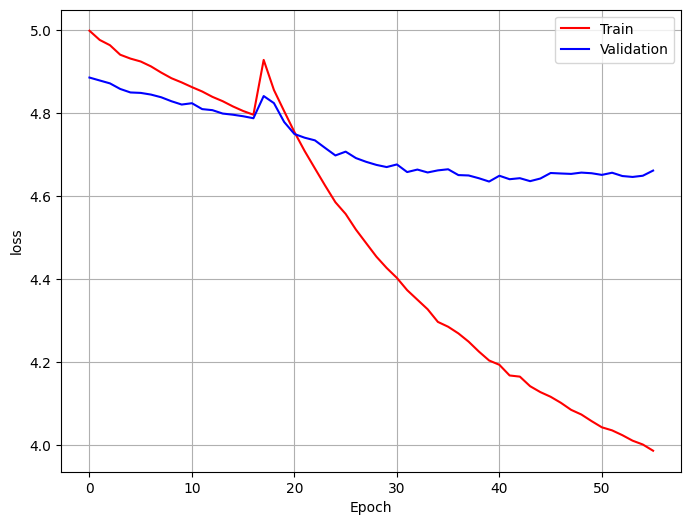

In [62]:
plt.figure(figsize = (8,6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label = "Train")
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label = "Validation")

plt.xlabel("Epoch")
plt.ylabel('loss')
plt.grid(True)
plt.legend()

#**Test**

In [64]:
model_path = 'language_model.pt'
model = torch.load(model_path)
model.eval()

LanguageModel(
  (embedding): Embedding(28782, 300)
  (lstms): ModuleList(
    (0): WeightDrop(
      (module): LSTM(300, 1150)
    )
    (1): WeightDrop(
      (module): LSTM(1150, 1150)
    )
    (2): WeightDrop(
      (module): LSTM(1150, 300)
    )
  )
  (fc): Linear(in_features=300, out_features=28782, bias=True)
  (lockdrop): LockedDropout()
)

In [65]:
loss_valid, metric_valid = evaluate(model, valid_loader, loss_fn, metric)
metric_valid

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:812: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:982.)
  result = _VF.lstm(input, hx, self._flat_weights, self.bias, self.num_layers,


103.43798828125

**Generate**

In [66]:
model_path = 'language_model.pt'
model = torch.load(model_path)
model.eval()

LanguageModel(
  (embedding): Embedding(28782, 300)
  (lstms): ModuleList(
    (0): WeightDrop(
      (module): LSTM(300, 1150)
    )
    (1): WeightDrop(
      (module): LSTM(1150, 1150)
    )
    (2): WeightDrop(
      (module): LSTM(1150, 300)
    )
  )
  (fc): Linear(in_features=300, out_features=28782, bias=True)
  (lockdrop): LockedDropout()
)

In [67]:
def generate(prompt, max_seq_len, temperature, mode, tokenizer, vocab, seed=None):
  if seed is not None:
    torch.manual_seed(seed)

  indices = vocab(tokenizer(prompt))
  itos = vocab.get_itos()

  for i in range(max_seq_len):
    src = torch.LongTensor(indices).to(device)

    with torch.no_grad():
      prediction = model(src)

    probs = torch.softmax(prediction[-1]/ temperature, dim = 0)

    idx = vocab['<ukn>']
    while idx == vocab['<ukn']:
      idx = torch.multinomial(probs, num_samples = 1).item()

    token = itos[idx]
    prompt += ' ' + token

    if idx == vocab['.']:
      return prompt

    indices.append(idx)

  return prompt

In [68]:
prompt_1 = 'In a galaxy far, far away, there'
prompt_2 = 'The sun was setting in the'
prompt_3 = 'Once upon a time, there lived a young princess named'
prompt_4 = 'What is the meaning '

generate(prompt_1, 35, 0.5, model, tokenizer, vocab)

'In a galaxy far, far away, there is a lot of people who have to do a lot of people .'

In [69]:
generate(prompt_2, 35, 0.5, model, tokenizer, vocab)

'The sun was setting in the second volume of the poem .'

In [70]:
generate(prompt_3, 35, 0.5, model, tokenizer, vocab)

"Once upon a time, there lived a young princess named , and was a child , from the art of the first time , and in the same year , he was a member of the company ' s department of education , a upper"

In [71]:
generate(prompt_4, 35, 0.5, model, tokenizer, vocab)

'What is the meaning  of the man of the dead .'